In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import  confusion_matrix
from sklearn.metrics import f1_score



df = pd.read_parquet("../data/Bot_data_.parquet")
df.head()


,Processing_Start_Time,Processing_End_Time,Status,Is_Success,Bot_Name_Anon
0,2024-01-01 00:00:18.583333,2024-01-01 00:00:45.083333,Business Error,True,Bot_004
1,2024-01-01 00:00:49.733333,2024-01-01 00:01:18.330000,Business Error,True,Bot_004
2,2024-01-01 00:01:23.043333,2024-01-01 00:01:49.846667,Business Error,True,Bot_004
3,2024-01-01 00:01:33.566667,2024-01-01 00:01:33.580000,Pending,False,Bot_017
4,2024-01-01 00:01:35.350000,2024-01-01 00:01:35.360000,Pending,False,Bot_017


In [15]:
# Convert Processing_Start_Time and Processing_End_Time to datetime
df["Processing_Start_Time"] = pd.to_datetime(df["Processing_Start_Time"], errors="coerce")
df["Processing_End_Time"] = pd.to_datetime(df["Processing_End_Time"], errors="coerce")

In [16]:
# Drop rows with invalid datetime entries
df = df.dropna(subset=["Processing_Start_Time", "Processing_End_Time"])

In [17]:
# Calculate Duration in seconds
df["Duration_sec"] = (df["Processing_End_Time"] - df["Processing_Start_Time"]).dt.total_seconds()

In [18]:
# Remove unrealistic durations (negative or over 2 hours)
df = df[(df["Duration_sec"] >= 0) & (df["Duration_sec"] <= 7200)]

In [19]:
# Standardize Status values
df["Status"] = (
    df["Status"]
    .str.strip()
    .str.lower()
    .str.replace("business error", "business_error")
    .str.replace("system error", "system_error")
    .str.replace("pending", "pending")
    .str.replace("success", "success")
)

In [20]:
has_duplicates = len(df) - len(set(df))
has_duplicates

9621110

In [21]:
# Ensure Is_Success is boolean
df["Is_Success"] = df["Is_Success"].astype(bool)

In [22]:
# Remove duplicate records
df = df.drop_duplicates()

In [23]:
# Remove rows with null Bot_Name_Anon
df = df[df["Bot_Name_Anon"].notnull()]

In [24]:
# Sort by Processing_Start_Time
df = df.sort_values(by="Processing_Start_Time")

In [25]:
# Remove rows with Status 'pending'
df = df[df["Status"] != "pending"]

In [26]:
# Create Error column
df["Error"] = (~df["Is_Success"]).astype(int)

In [27]:
# Final cleaned data overview
print("Cleaned data shape:", df.shape)
df.head()

Cleaned data shape: (3110670, 7)


,Processing_Start_Time,Processing_End_Time,Status,Is_Success,Bot_Name_Anon,Duration_sec,Error
0,2024-01-01 00:00:18.583333,2024-01-01 00:00:45.083333,business_error,True,Bot_004,26.500000,0
1,2024-01-01 00:00:49.733333,2024-01-01 00:01:18.330000,business_error,True,Bot_004,28.596667,0
2,2024-01-01 00:01:23.043333,2024-01-01 00:01:49.846667,business_error,True,Bot_004,26.803334,0
15,2024-01-01 00:01:54.486667,2024-01-01 00:02:21.373333,business_error,True,Bot_004,26.886666,0
34,2024-01-01 00:02:25.986667,2024-01-01 00:02:52.946667,business_error,True,Bot_004,26.960000,0


In [28]:
df.groupby('Bot_Name_Anon')['Duration_sec'].agg(['mean','median','min','max','std','count'])


,mean,median,min,max,std,count
Bot_Name_Anon,,,,,,
Bot_001,1010.389972,493.403334,61.670000,6997.513333,1098.713057,2891
Bot_002,25.767570,26.490000,0.266666,396.503334,9.162392,136705
Bot_003,50.601014,23.380000,0.000000,2439.160000,92.583083,36049
Bot_004,26.159943,26.476667,20.656666,28.880000,1.579739,117
Bot_005,101.302014,86.346667,9.800000,5621.003333,131.754254,136252
Bot_006,45.488383,47.593333,0.003333,1180.783333,29.255752,108672
Bot_007,1299.644965,539.863334,0.006667,7199.443333,1710.697246,43113
Bot_008,119.537264,133.316666,20.343334,163.286667,42.068499,67
Bot_009,2628.092412,2196.953333,0.003333,7199.810000,1859.715864,31487


Text(0.5, 1.0, 'Error Rate by Bot')

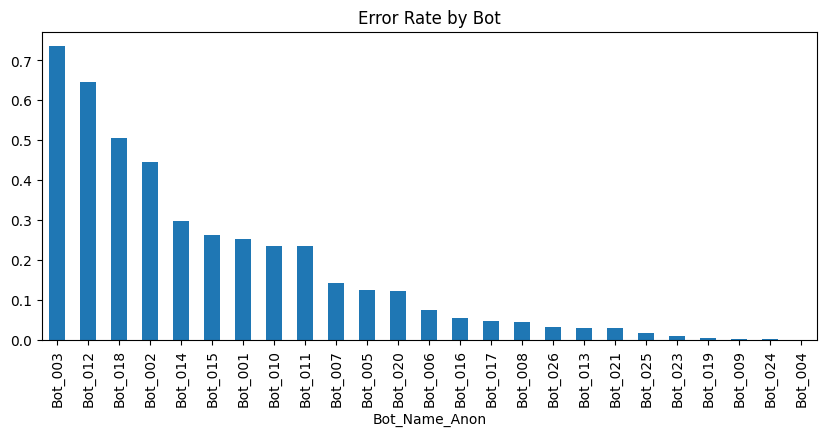

In [29]:
df['Error'] = df['Is_Success'] == False

error_by_bot = df.groupby('Bot_Name_Anon')['Error'].mean().sort_values(ascending=False)
error_by_bot.plot(kind='bar', figsize=(10,4))
plt.title('Error Rate by Bot')


Text(0.5, 1.0, 'Distribution of Duration (seconds)')

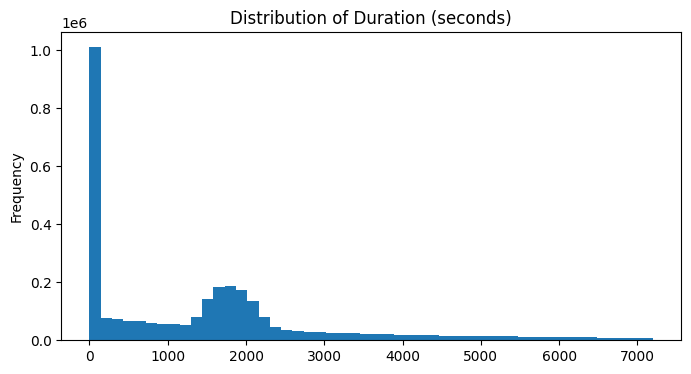

In [30]:
df['Duration_sec'].plot(kind='hist', bins=50, figsize=(8,4))
plt.title('Distribution of Duration (seconds)')

Text(0.5, 1.0, 'Number of Records by Date')

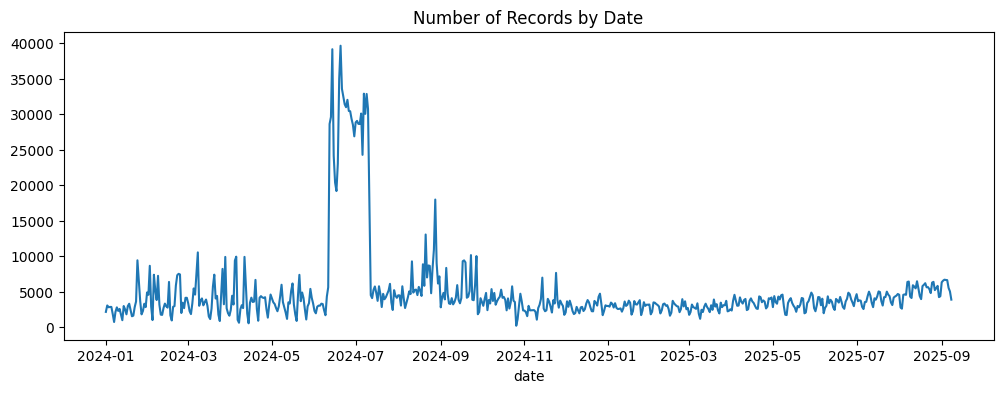

In [31]:
df['date'] = df['Processing_Start_Time'].dt.date
df.groupby('date').size().plot(figsize=(12,4))
plt.title('Number of Records by Date')

Text(0.5, 1.0, 'Number of Records by Hour of Day')

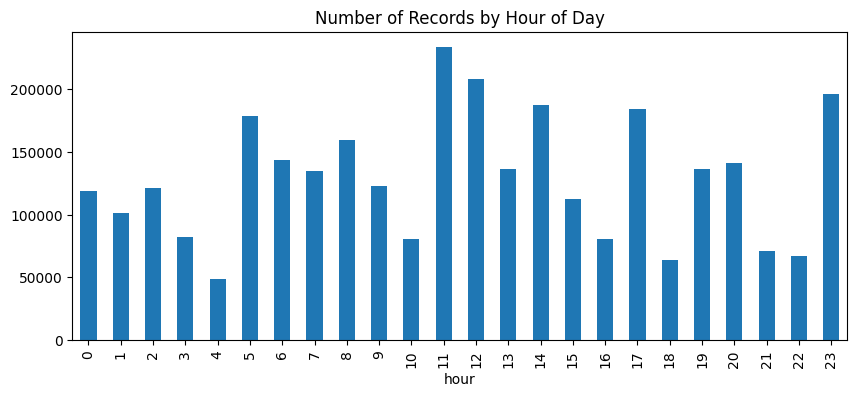

In [32]:
df['hour'] = df['Processing_Start_Time'].dt.hour
df.groupby('hour').size().plot(kind='bar', figsize=(10,4))
plt.title('Number of Records by Hour of Day')


In [56]:
# SLA compliance: proportion of tasks completed within 60 seconds
sla_limit = 60
sla_compliance = (df["Duration_sec"] <= sla_limit).mean()
sla_compliance

np.float64(0.2586111673690877)

Text(0.5, 1.0, 'Task Status Distribution')

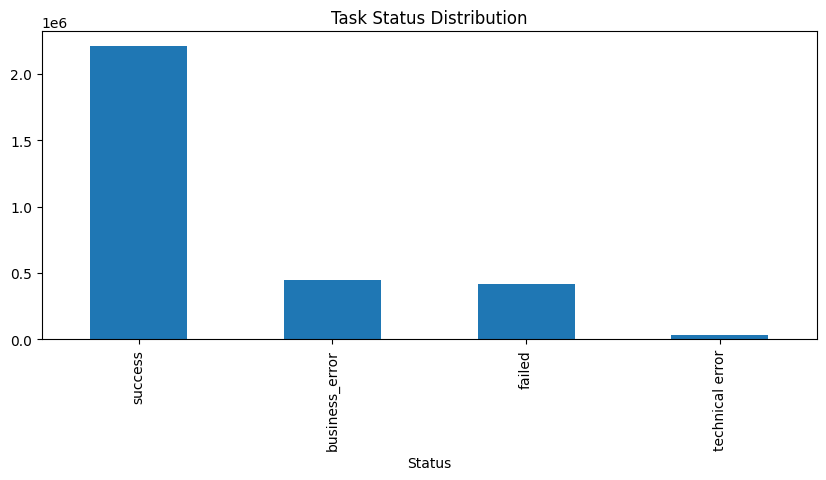

In [34]:
df['Status'].value_counts().plot(kind='bar', figsize=(10,4))
plt.title('Task Status Distribution')

Text(0.5, 1.0, 'Daily Error Rate Trend')

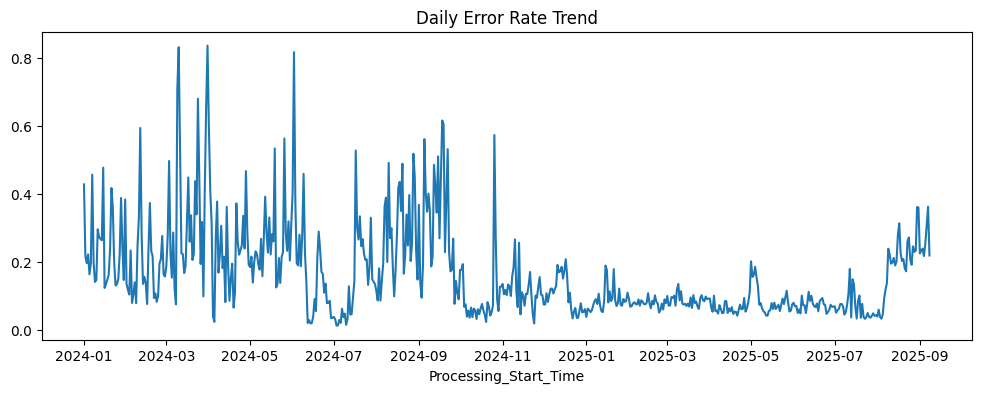

In [35]:
error_trend = df.groupby(df['Processing_Start_Time'].dt.date)['Error'].mean()
error_trend.plot(figsize=(12,4))
plt.title('Daily Error Rate Trend')

Text(0.5, 1.0, 'Duration Distribution by Bot Name')

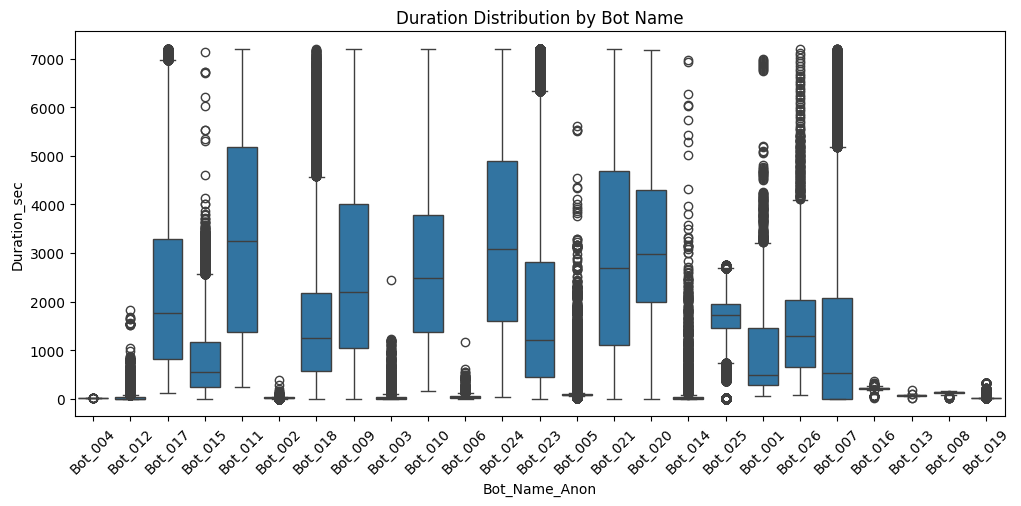

In [36]:
# Boxplot of Duration by Bot_Name_Anon
plt.figure(figsize=(12,5))
sns.boxplot(data=df, x='Bot_Name_Anon', y='Duration_sec')
plt.xticks(rotation=45)
plt.title('Duration Distribution by Bot Name')

In [ ]:
# Top 10 slowest executions
df.nlargest(10, 'Duration_sec')


,Processing_Start_Time,Processing_End_Time,Status,Is_Success,Bot_Name_Anon,Duration_sec,Error,date,hour
5189426,2024-12-12 12:03:37.383333,2024-12-12 14:03:37.373333,success,True,Bot_023,7199.990000,False,2024-12-12,12
1251042,2024-04-30 22:01:32.616667,2024-05-01 00:01:32.590000,failed,False,Bot_017,7199.973333,True,2024-04-30,22
7256549,2025-04-30 12:08:47.993333,2025-04-30 14:08:47.963333,success,True,Bot_023,7199.970000,False,2025-04-30,12
6536569,2025-03-15 07:03:28.703333,2025-03-15 09:03:28.663333,success,True,Bot_024,7199.960000,False,2025-03-15,7
1375389,2024-05-12 01:27:55.420000,2024-05-12 03:27:55.363333,success,True,Bot_024,7199.943333,False,2024-05-12,1
4007361,2024-09-16 03:02:59.526667,2024-09-16 05:02:59.456667,success,True,Bot_024,7199.930000,False,2024-09-16,3
4409530,2024-10-11 06:59:31.043333,2024-10-11 08:59:30.953333,business_error,True,Bot_021,7199.910000,False,2024-10-11,6
8336861,2025-07-02 21:01:01.770000,2025-07-02 23:01:01.650000,success,True,Bot_021,7199.880000,False,2025-07-02,21
4864725,2024-11-15 01:03:38.956667,2024-11-15 03:03:38.820000,business_error,True,Bot_024,7199.863333,False,2024-11-15,1
1501596,2024-05-23 01:23:03.200000,2024-05-23 03:23:03.020000,success,True,Bot_024,7199.820000,False,2024-05-23,1


In [38]:
# Extract hour of day
df['Hour'] = df['Processing_Start_Time'].dt.hour

# Pearson correlation
pearson_corr = df[['Hour', 'Error']].corr(method='pearson').iloc[0,1]

print("Pearson correlation between hour of day and error rate:", pearson_corr)

Pearson correlation between hour of day and error rate: -0.014610603468173089


In [39]:
# extract time-based features
df["hour"] = df["Processing_Start_Time"].dt.hour
df["weekday"] = df["Processing_Start_Time"].dt.weekday
df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)

In [40]:
# extract month
df["month"] = df["Processing_Start_Time"].dt.month

In [41]:
# Ensure Bot_Name_Anon is categorical
df["Bot_Name_Anon"] = df["Bot_Name_Anon"].astype("category")

In [42]:
df["bot_error_rate_prev"] = (
    df.groupby("Bot_Name_Anon")["Error"]
      .transform(lambda x: x.shift(1).expanding().mean())
)

global_error_rate = df["Error"].mean()
df["bot_error_rate_prev"] = df["bot_error_rate_prev"].fillna(global_error_rate)

C:\Users\maxdo\AppData\Local\Temp\ipykernel_3828\2762546321.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("Bot_Name_Anon")["Error"]


In [43]:
df = df.sort_values(["Bot_Name_Anon", "Processing_Start_Time"]).reset_index(drop=True)

In [44]:
def compute_run_count_last_hour(group):
  group = group.set_index("Processing_Start_Time")
  group["run_count_last_1h"] = (
        group["Error"]
        .rolling("3600s")
        .count()
        .shift(1)
    )
  return group
    

In [45]:
df = (
    df.groupby("Bot_Name_Anon", group_keys=False)
      .apply(compute_run_count_last_hour)
)

C:\Users\maxdo\AppData\Local\Temp\ipykernel_3828\1941949570.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("Bot_Name_Anon", group_keys=False)
C:\Users\maxdo\AppData\Local\Temp\ipykernel_3828\1941949570.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_run_count_last_hour)


In [46]:
df["run_count_last_1h"] = df["run_count_last_1h"].fillna(0)

In [47]:
# Define features and target variable
features = [
    "Bot_Name_Anon",
    "Duration_sec",
    "hour",
    "weekday",
    "is_weekend",
    "month",
    "bot_error_rate_prev",
    "run_count_last_1h"   
]

target = "Error"

In [48]:
# Sort by Processing_Start_Time
df = df.sort_values("Processing_Start_Time").reset_index(drop=True)

X = df[features]
y = df[target]

In [49]:
# Split data
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]

X_test  = X.iloc[split_index:]
y_test  = y.iloc[split_index:]

In [50]:
# Prepare CatBoost Pools
cat_features = ["Bot_Name_Anon", "weekday", "is_weekend", "month", "hour"]

train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_features)

In [51]:
# Train CatBoost model
model = CatBoostClassifier(
    iterations=500,
    depth=8,
    learning_rate=0.05,
    loss_function="Logloss",
    eval_metric="AUC",
    verbose=100,
    random_seed=42
)

model.fit(train_pool, eval_set=test_pool)

0:	test: 0.8259517	best: 0.8259517 (0)	total: 1.19s	remaining: 9m 53s
100:	test: 0.8280672	best: 0.8576003 (16)	total: 1m 32s	remaining: 6m 6s
200:	test: 0.8371959	best: 0.8576003 (16)	total: 3m 11s	remaining: 4m 44s
300:	test: 0.8452726	best: 0.8576003 (16)	total: 4m 46s	remaining: 3m 9s
400:	test: 0.8374560	best: 0.8576003 (16)	total: 6m 22s	remaining: 1m 34s
499:	test: 0.8336203	best: 0.8576003 (16)	total: 8m 1s	remaining: 0us

bestTest = 0.8576002542
bestIteration = 16

Shrink model to first 17 iterations.


In [52]:
# Results
y_pred = model.predict(test_pool)
y_proba = model.predict_proba(test_pool)[:,1]

print("\nClassification Results")
print(classification_report(y_test, y_pred))

print("AUC:", roc_auc_score(y_test, y_proba))


Classification Results
              precision    recall  f1-score   support

       False       0.91      0.98      0.94    549294
        True       0.56      0.23      0.33     72840

    accuracy                           0.89    622134
   macro avg       0.73      0.60      0.63    622134
weighted avg       0.86      0.89      0.87    622134

AUC: 0.8576002541903986


In [ ]:

# Optimize threshold for ERROR class
thresholds = np.arange(0.01, 0.70, 0.01)

best_threshold = 0.5
best_f1 = 0

for th in thresholds:
    y_pred_adj = (y_proba >= th).astype(int)
    f1 = f1_score(y_test, y_pred_adj, pos_label=1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = th

print("Best threshold:", best_threshold)
print("Best F1 for ERROR class:", best_f1)

Best threshold: 0.33
Best F1 for ERROR class: 0.49526816007986457


In [ ]:
# Predictions with optimal threshold

y_pred_optimal = (y_proba >= best_threshold).astype(int)

print("\nMetrics at Optimal Threshold")
print(classification_report(y_test, y_pred_optimal))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_optimal))



Metrics at Optimal Threshold
              precision    recall  f1-score   support

       False       0.93      0.93      0.93    549294
        True       0.49      0.50      0.50     72840

    accuracy                           0.88    622134
   macro avg       0.71      0.72      0.71    622134
weighted avg       0.88      0.88      0.88    622134

Confusion matrix:
[[510595  38699]
 [ 36128  36712]]


Duration_sec: 32.2206
month: 22.2918
run_count_last_1h: 19.8582
bot_error_rate_prev: 19.6657
Bot_Name_Anon: 4.0665
is_weekend: 1.8971
hour: 0.0000
weekday: 0.0000


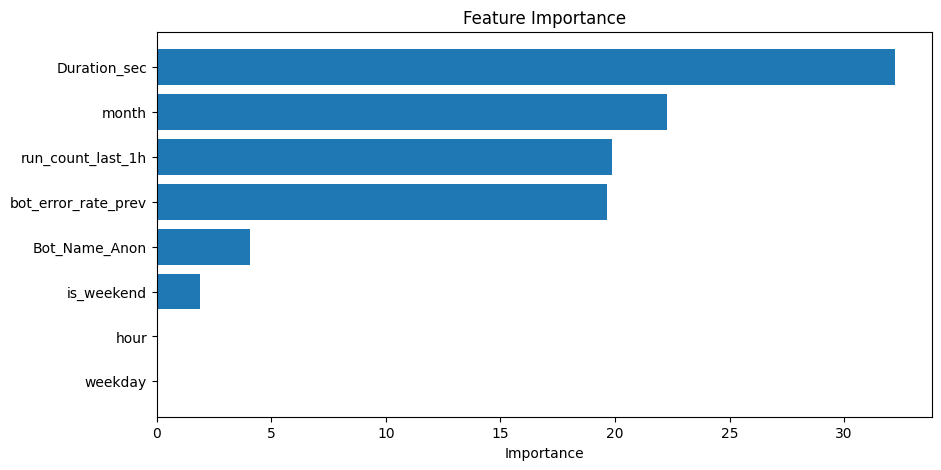

In [57]:
# Feature importance
feature_importances = model.get_feature_importance(train_pool)
fi = list(zip(features, feature_importances))
fi_sorted = sorted(fi, key=lambda x: x[1], reverse=True)
for f, imp in fi_sorted:
    print(f"{f}: {imp:.4f}")


sorted_features = [x[0] for x in fi_sorted]
sorted_importances = [x[1] for x in fi_sorted]


plt.figure(figsize=(10, 5))
plt.barh(sorted_features, sorted_importances)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()
